# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Set options

figsize = (16, 6)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# import dataset

In [3]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df.head(3)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 11.6 MB


In [5]:
df.Datetime = pd.to_datetime(df.Datetime)
df.set_index('Datetime', inplace=True)
df.head(3)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0


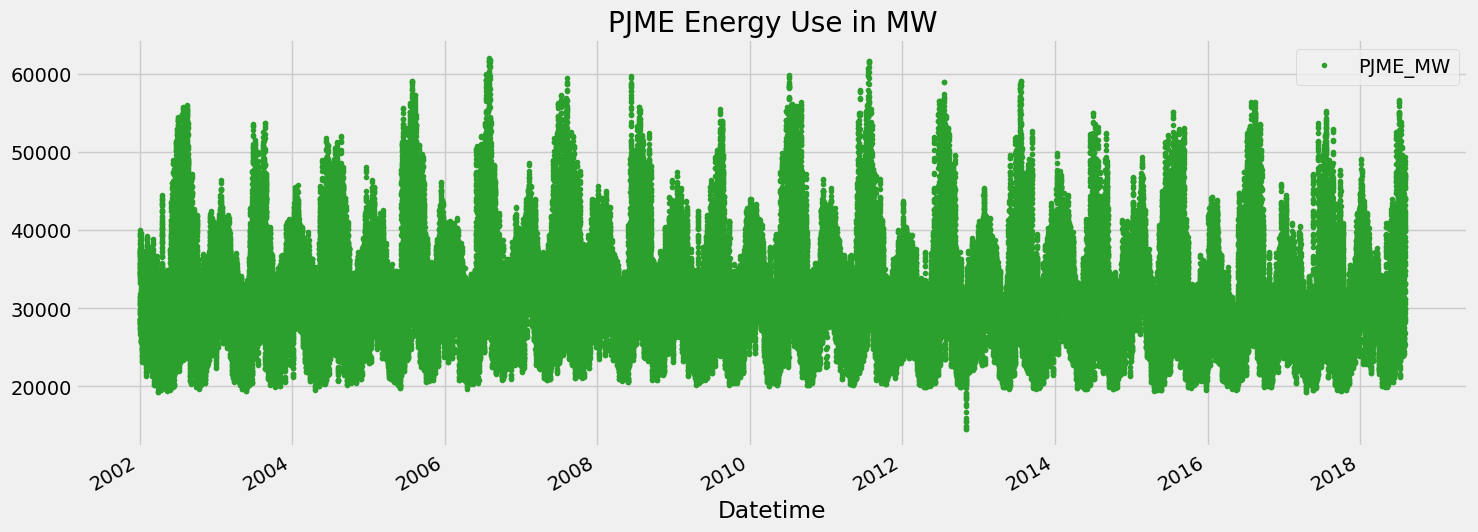

In [6]:
df.plot(figsize=figsize, style='.', color=color_pal[2], title='PJME Energy Use in MW')
plt.show()

# Outlier handlingOutlier Analysis and removal

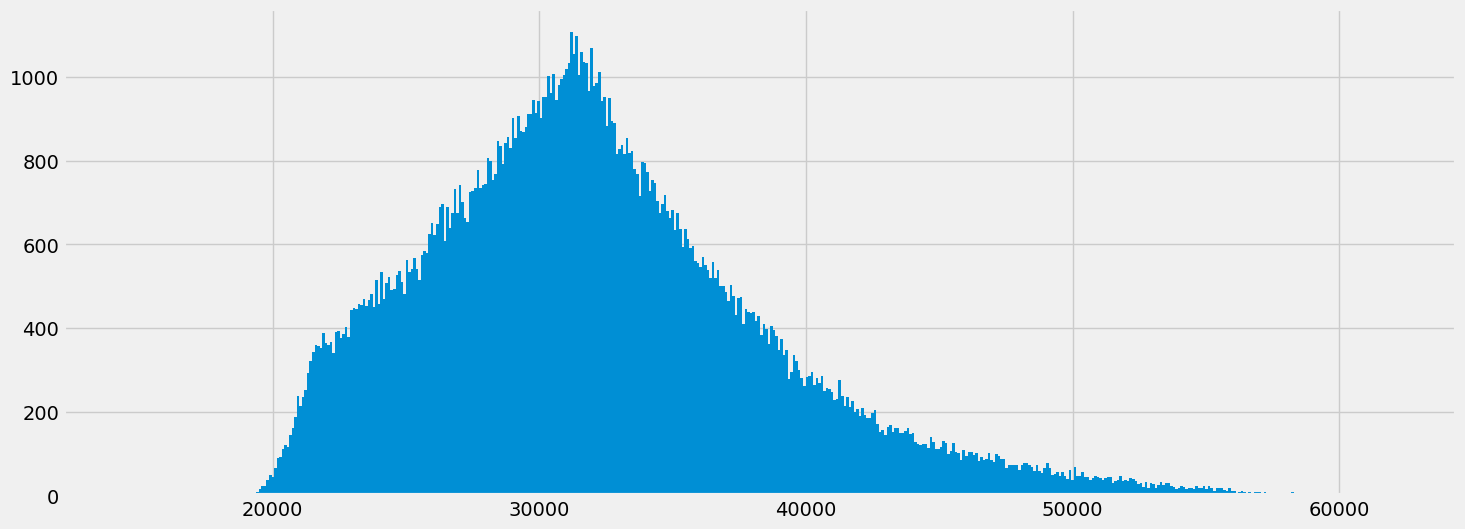

In [7]:
df.PJME_MW.hist(bins=500, figsize=figsize)
plt.show()

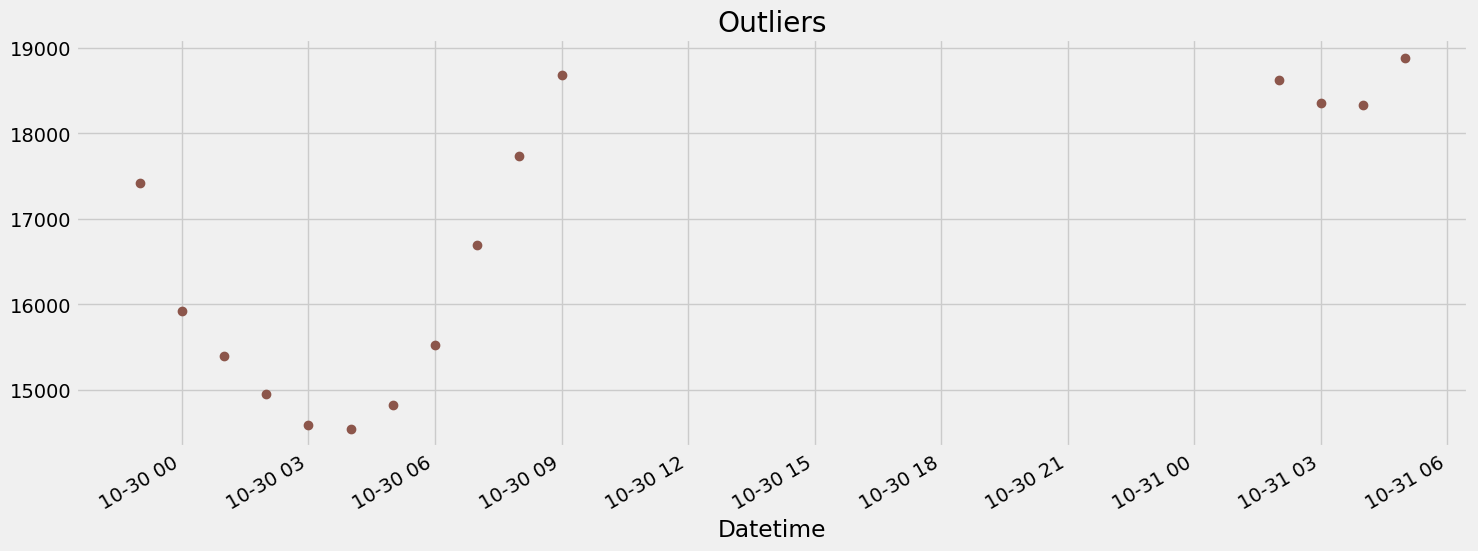

In [8]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='o', figsize=figsize, color=color_pal[5], title='Outliers')
plt.show()

In [9]:
df = df.query('PJME_MW > 19_000').copy()
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145351 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145351 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


# Train / Test Split

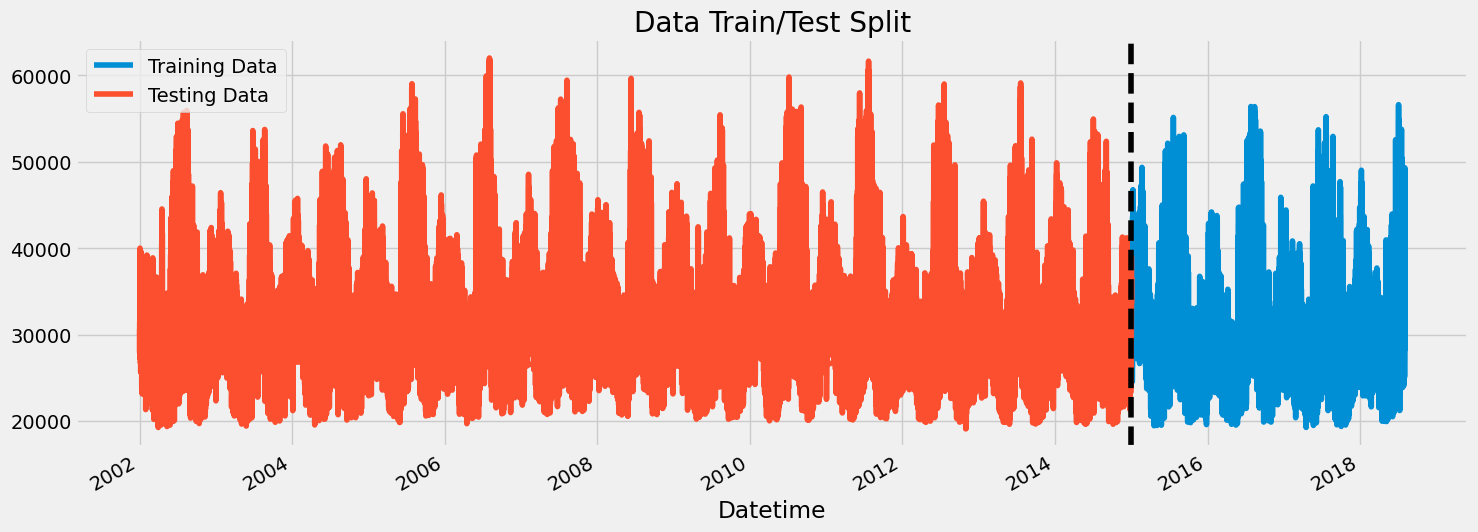

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=figsize)

test.plot(ax=ax, label='Test')
train.plot(ax=ax, label='Training', title='Data Train/Test Split')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Data', 'Testing Data'])

plt.show()

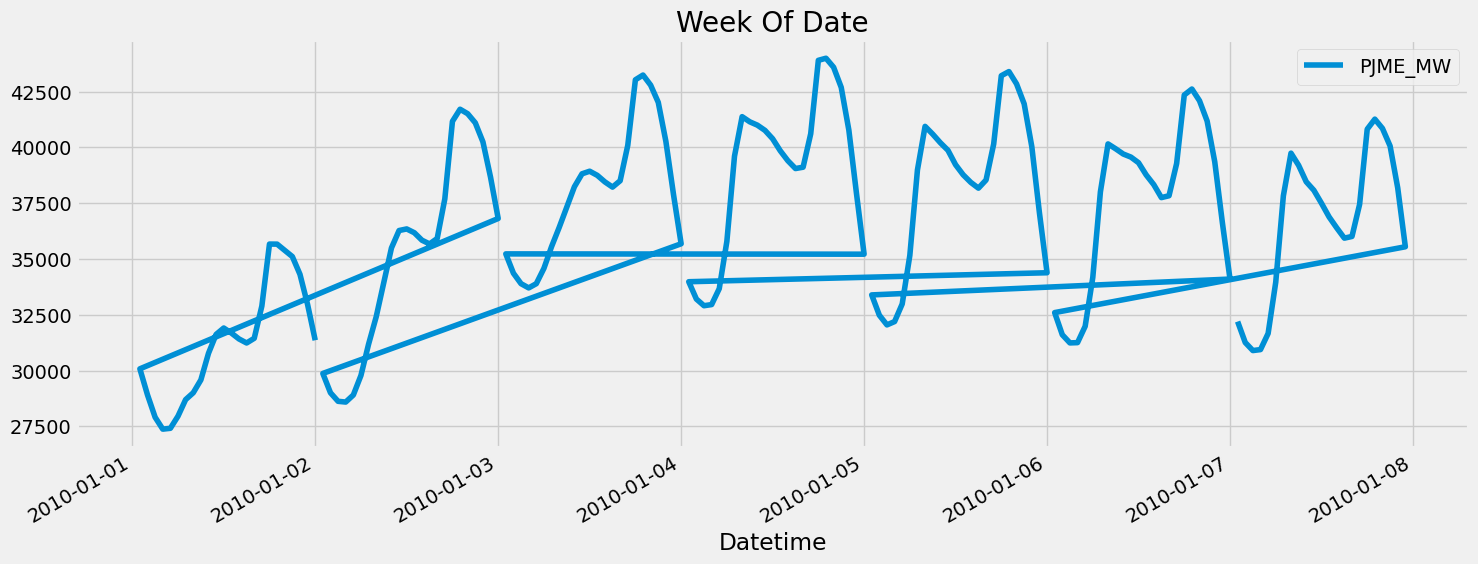

In [11]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(kind='line', figsize=figsize, title='Week Of Date')
plt.show()

# TimeSeries Cross Validation

In [12]:
df.sort_index(inplace=True)

time_series_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

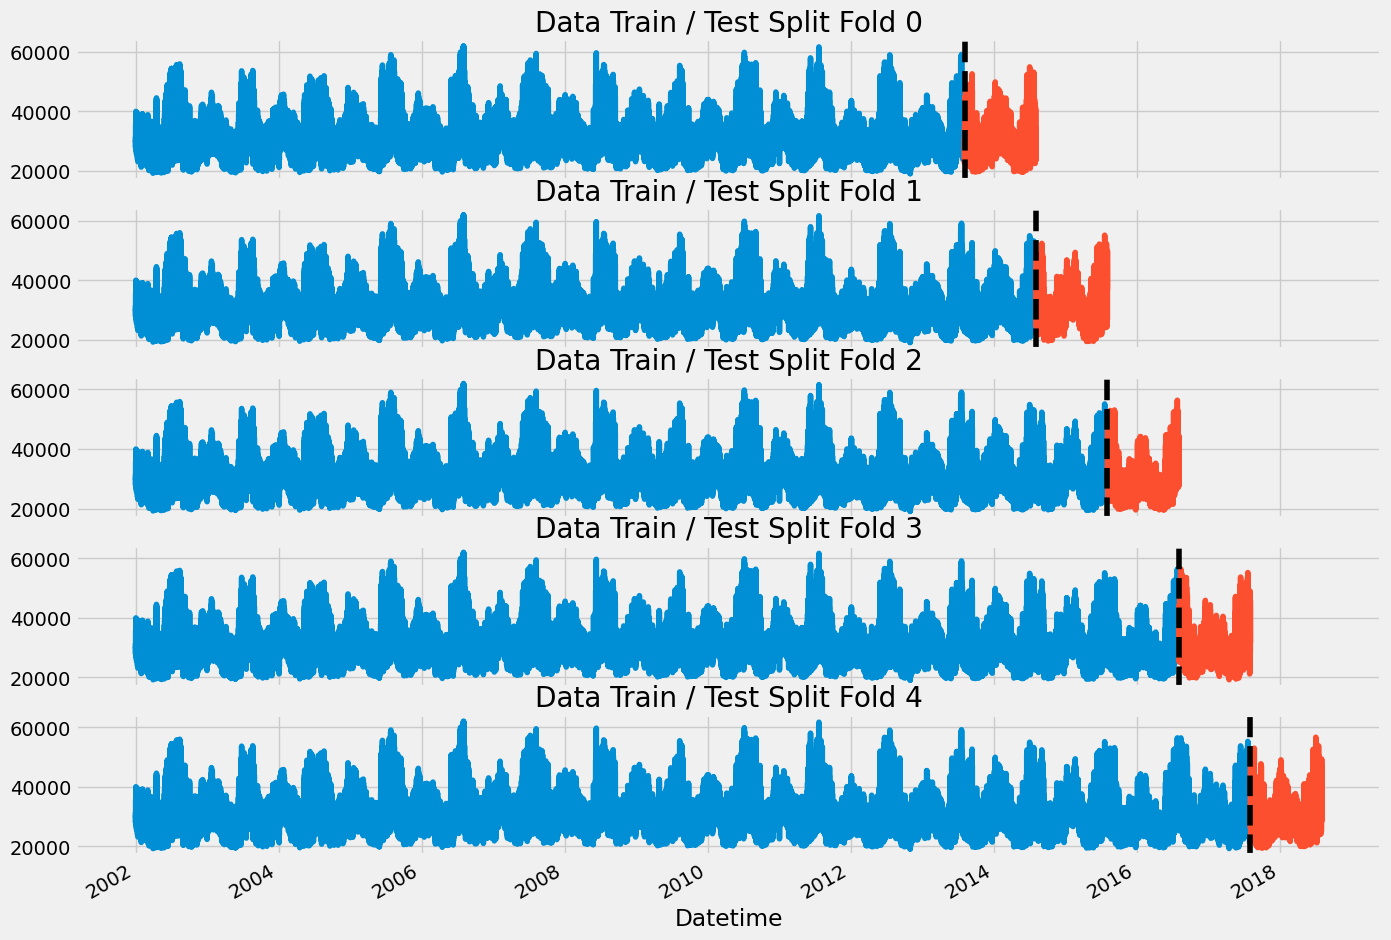

In [13]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

fold = 0

for train_idx, val_idx in time_series_split.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train.PJME_MW.plot(ax=axs[fold], label='Training Set', title=f'Data Train / Test Split Fold {fold}')
    test.PJME_MW.plot(ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    fold += 1

plt.show()

# Feature Creation

In [14]:
def generate_features(df):
    """
    Create time series features based on time series index.
    """

    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['dayofmonth'] = new_df.index.day
    new_df['weekofyear'] = new_df.index.isocalendar().week

    return new_df

In [15]:
df = generate_features(df)
df.sample(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-06-05 17:00:00,27991.0,17,5,2,6,2004,157,5,23
2012-01-26 14:00:00,34519.0,14,3,1,1,2012,26,26,4
2010-07-20 05:00:00,31699.0,5,1,3,7,2010,201,20,29
2005-03-05 16:00:00,29852.0,16,5,1,3,2005,64,5,9
2011-01-12 18:00:00,43174.0,18,2,1,1,2011,12,12,2


# Lag Features

In [16]:
def add_lags(df):
    target_map = df.PJME_MW.to_dict()
    
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

    return df

In [17]:
df = add_lags(df)
df.sample(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2005-09-19 05:00:00,25593.0,5,0,3,9,2005,262,19,38,21202.0,22685.0,25956.0
2016-01-13 00:00:00,32958.0,0,2,1,1,2016,13,13,2,35387.0,29200.0,29655.0
2009-06-10 18:00:00,38206.0,18,2,2,6,2009,161,10,24,49310.0,37179.0,36923.0
2015-08-24 23:00:00,37387.0,23,0,3,8,2015,236,24,35,33518.0,36077.0,38616.0
2013-06-09 12:00:00,30018.0,12,6,2,6,2013,160,9,23,35842.0,33490.0,40671.0


# Visualize our Feature / Target Relationship

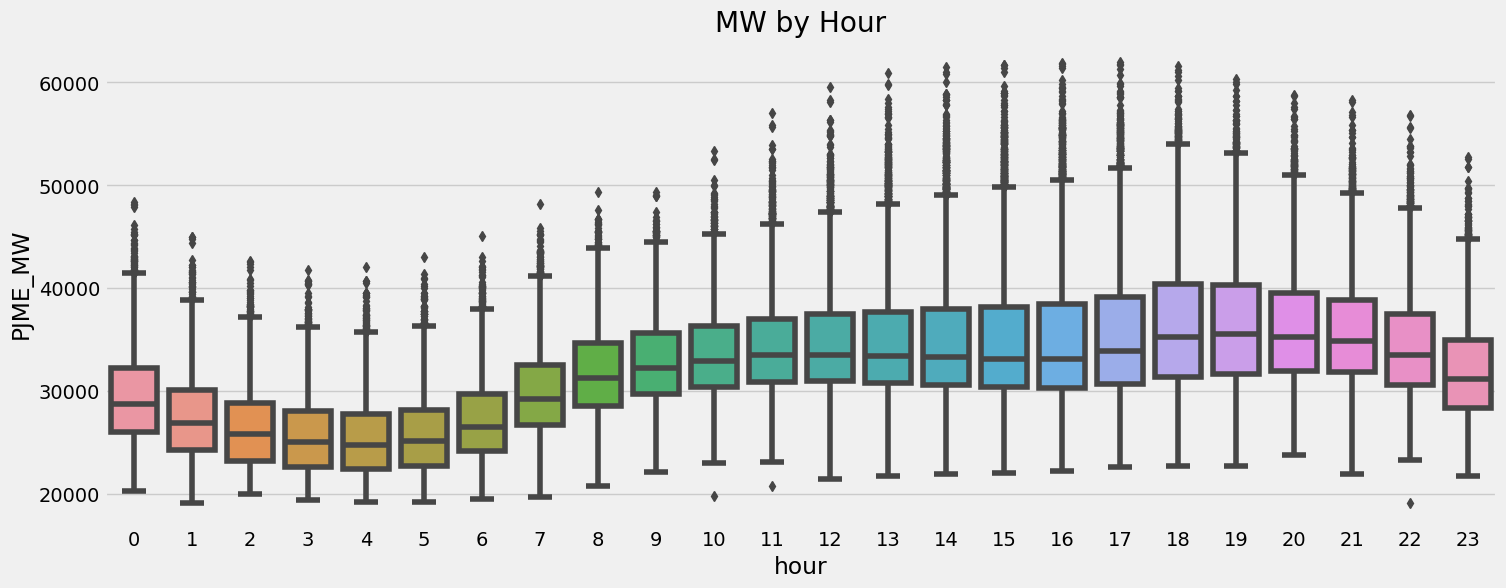

In [18]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_title('MW by Hour')
sns.boxplot(data=df, x='hour', y='PJME_MW')

plt.show()

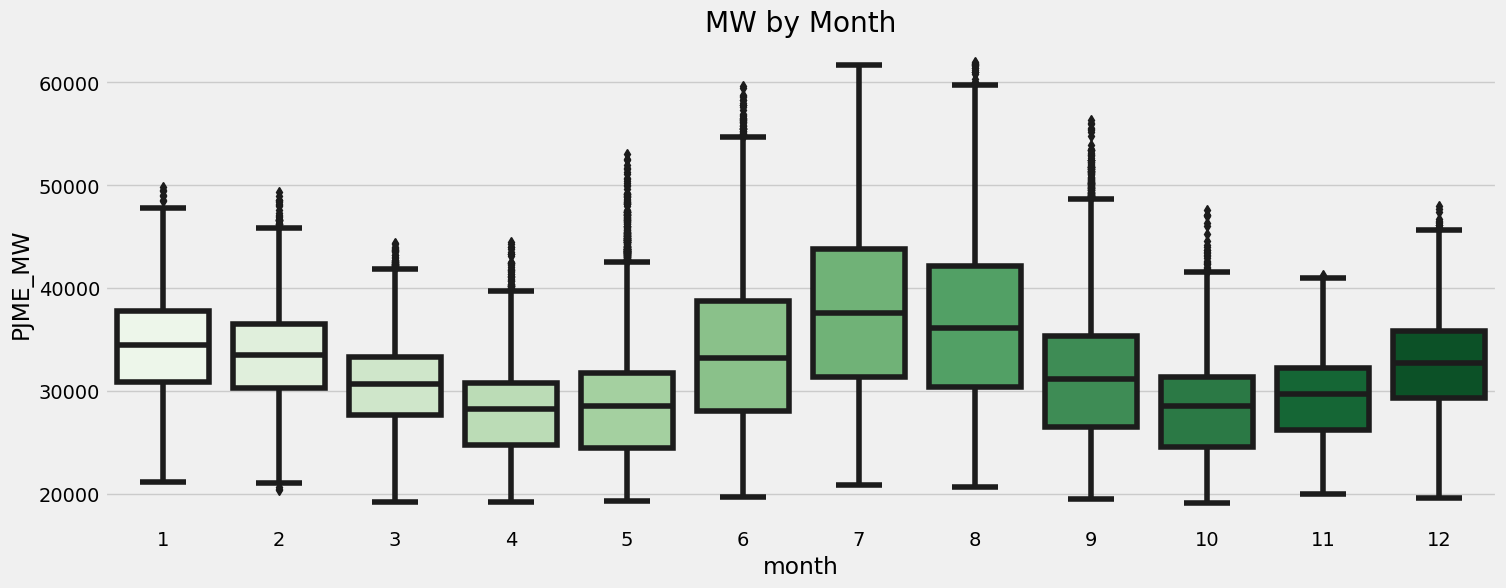

In [19]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_title('MW by Month')
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Greens')

plt.show()

# Create Model

In [20]:
standard_scaler = StandardScaler()

In [21]:
fold = 0
predictions = []
scores = []

label = 'PJME_MW'
features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','lag1','lag2','lag3']

for train_idx, validation_idx in time_series_split.split(df):
    train = generate_features(df.iloc[train_idx])
    test = generate_features(df.iloc[validation_idx])

    X_train = standard_scaler.fit_transform(train[features])
    y_train = train[label]

    X_test = standard_scaler.transform(test[features])
    y_test = test[label]

    model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, max_depth=3, learning_rate=0.01)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_prediction = model.predict(X_test)
    
    predictions.append(y_prediction)
    scores.append(np.sqrt(mean_squared_error(y_test, y_prediction)))

[0]	validation_0-rmse:6457.15341	validation_1-rmse:6143.15464
[100]	validation_0-rmse:4367.61761	validation_1-rmse:4107.31848
[200]	validation_0-rmse:3811.05165	validation_1-rmse:3767.45549
[300]	validation_0-rmse:3537.90755	validation_1-rmse:3718.59114
[337]	validation_0-rmse:3469.93151	validation_1-rmse:3725.48352
[0]	validation_0-rmse:6432.67201	validation_1-rmse:6250.31176
[100]	validation_0-rmse:4370.38556	validation_1-rmse:4161.71011
[200]	validation_0-rmse:3834.60508	validation_1-rmse:3702.96107
[300]	validation_0-rmse:3577.46290	validation_1-rmse:3557.94999
[400]	validation_0-rmse:3431.04958	validation_1-rmse:3523.30431
[500]	validation_0-rmse:3347.65554	validation_1-rmse:3503.17686
[600]	validation_0-rmse:3296.98738	validation_1-rmse:3481.92088
[700]	validation_0-rmse:3258.00275	validation_1-rmse:3468.14492
[800]	validation_0-rmse:3221.57310	validation_1-rmse:3442.57635
[900]	validation_0-rmse:3192.92958	validation_1-rmse:3434.12419
[999]	validation_0-rmse:3168.33083	validatio

In [22]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3741.3741
Fold scores:[3718.0015769374436, 3428.764177052716, 3606.992569867626, 4093.6407414168875, 3859.471556695046]


# Predict

In [23]:
df = generate_features(df)

X = df[features]
y = df[label]

model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500,
                       objective='reg:linear', max_depth=3, learning_rate=0.01)

model.fit(X, y, eval_set=[(X, y)], verbose=100)

[0]	validation_0-rmse:32403.88991


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:47:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [24]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [25]:
future_df = pd.DataFrame(index=pd.date_range('2018-08-03','2019-08-01', freq='1h'))

df['isFuture'] = False
future_df['isFuture'] = True

df_and_future = pd.concat([df, future_df])
df_and_future = generate_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()

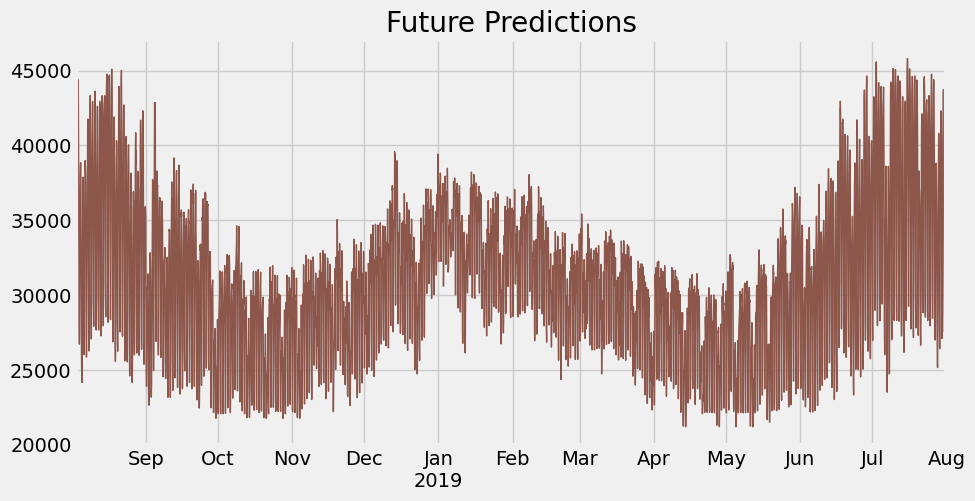

In [26]:
future_w_features['pred'] = model.predict(future_w_features[features])

future_w_features['pred'].plot(figsize=(10, 5), color=color_pal[5], ms=1, lw=1, title='Future Predictions')
plt.show()

# Feature Importance

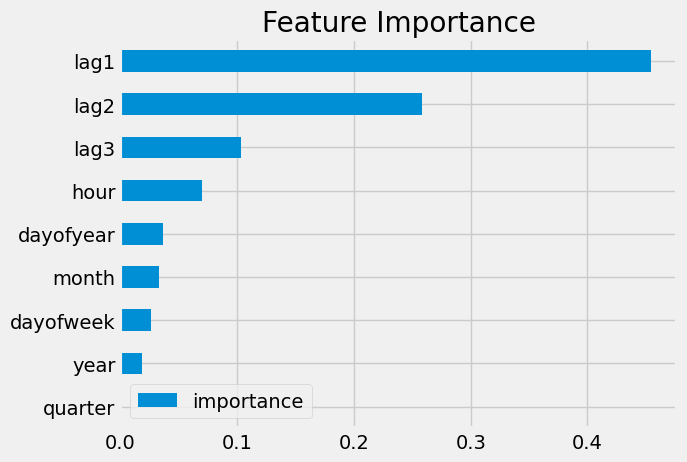

In [27]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_, columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()